# Adaptive Boosting (AdaBoost) for classification with Python

## Objectives

*   Understand  that AdaBoost is a linear combination of  𝑇 weak classifiers
*   Apply AdaBoost
*   Understand Hyperparameters selection in  AdaBoost


In this notebook, you will work with AdaBoost, short for Adaptive Boosting, is a classification algorithm; AdaBoost is actually part of a family of Boosting algorithms. Like Bagging and Random Forest (RF), AdaBoost combines the outputs of many classifiers into an ensemble, but there are some differences. In both Bagging and RF, each classifier in the ensemble is powerful but prone to overfitting. As Bagging or RF aggregate more and more classifiers, they reduce overfitting.

With AdaBoost, each Classifier usually has performance slightly better than random. This is referred to as a weak learner or weak classifier. AdaBoost combines these classifiers to get a strong classifier. Unlike Bagging and Random Forest, in AdaBoost, adding more learners can cause overfitting. As a result, AdaBoost requires Hyperparameter tuning, taking more time to train. One advantage of AdaBoost is that each classifier is smaller, so predictions are faster.


In AdaBoost, the strong classifier $H(x)$ is a linear combination of $T$ weak classifiers $h_t(x)$ and $\alpha_t$ as shown in (1). Although each classifier $h_t(x)$ appears independent, the $\alpha_t$ contains information about the error of classifiers from $h_1(x),.., h_{t-1}(x)$. As we add more classifiers, the training accuracy gets larger. What’s not so apparent in (1) is that during the training process, the values of that training sample are modified for $h_t(x)$. For a more in depth look at the theory behind Adaboost, check out <a href="https://hastie.su.domains/Papers/ESLII.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01#page=356">The Elements of Statistical Learning Data Mining, Inference, and Prediction</a>.


$H(x) = 	ext{sign}(  \sum_{t=1}^T \alpha_t h_t(x) )$ [1]


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#RFvsBag">What's the difference between RF and Bagging </a></li>
        <li><a href="https://#Example">Cancer Data Example</li>
        <li><a href="https://practice/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">Practice</a></li>

</div>
<br>
<hr>


Let's first import the required libraries:


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [1]:
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib   
!pip install seaborn


In [3]:
import pandas as pd
import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm


Ignore error warnings


In [5]:
import warnings
warnings.filterwarnings('ignore')

This function will calculate the accuracy of the training and testing data given a model.


In [7]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

This function calculates the average accuracy of differnt learning rates on training and test data


In [9]:
def get_accuracy_bag(X,y,title,times=20,xlabel='Number Estimators',Learning_rate_=[0.2,0.4,0.6,1]):

    lines_array=['solid','--', '-.', ':']

    N_estimators=[n for n in range(1,100)]
    
    times=20
    train_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))
    test_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))


    #Iterate through different number of Learning rate  and average out the results  
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            for j,lr in enumerate(Learning_rate_):


                model = AdaBoostClassifier(n_estimators=n_estimators+1,random_state=0,learning_rate=lr)


                model.fit(X_train,y_train)



                Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  model)



                train_acc[n,j,n_estimators-1]=Accuracy['train Accuracy']
                test_acc[n,j,n_estimators-1]=Accuracy['test Accuracy']




    fig, ax1 = plt.subplots()
    mean_test=test_acc.mean(axis=0)
    mean_train=train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j,(lr,line) in enumerate(zip(Learning_rate_,lines_array)): 

        ax1.plot(mean_train[j,:],linestyle = line,color='b',label="Learning rate "+str(lr))
        ax2.plot(mean_test[j,:],linestyle = line, color='r',label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.set_xlabel('No of estimators')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    plt.show()

### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than to acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they have been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


Load Data From CSV File


In [11]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv")

churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


### Data pre-processing and selection


Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [13]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


### Select Variables at Random


Like Bagging, RF uses an independent bootstrap sample from the training data. In addition, we select $m$ variables at random out of all $M$ possible
variables. Let's do an example.


In [15]:
X=churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]

there are 7 features


## Train/Test dataset


Let's define X, and y for our dataset:


In [17]:
y = churn_df['churn']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int32

## Train/Test dataset


We split our dataset into train and test set:


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (140, 7) (140,)
Test set (60, 7) (60,)


## AdaBoost


We can import the AdaBoost Classifier in Sklearn


In [21]:
from sklearn.ensemble import AdaBoostClassifier

The parameter <code>n_estimatorsint</code> is the maximum number of classifiers (default=50) at which boosting is stopped. If the results are perfect, the training procedure is stopped early.


In [23]:
n_estimators=5
random_state=0

We can create a <code>AdaBoostClassifier</code> object.


In [25]:
model = AdaBoostClassifier(n_estimators=n_estimators,random_state=random_state)

If the outputs were y-1 and 1, the form of the classifier would be:


$H(x) = 	ext{sign}(  \alpha_1 h_1(x)+ \alpha_2 h_2(x)+ \alpha_3 h_3(x)+ \alpha_4 h_4(x)+ \alpha_5 h_5(x) )$


We can fit the object finding all the $\alpha_t$ $h_t(x)$ and then make a prediction:


In [28]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred 

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

We can find the training and testing accuracy:


In [30]:
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.7642857142857142}


We see the base model is a Decision Tree. Since it only has one layer, it’s called a stump:


In [32]:
model.estimator_

DecisionTreeClassifier(max_depth=1)

We can output a list of the weak classifiers: $h_1(x), h_2(x), h_3(x),h_4(x)$ and $h_5(x)$


In [34]:
model.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=209652396),
 DecisionTreeClassifier(max_depth=1, random_state=398764591),
 DecisionTreeClassifier(max_depth=1, random_state=924231285),
 DecisionTreeClassifier(max_depth=1, random_state=1478610112),
 DecisionTreeClassifier(max_depth=1, random_state=441365315)]

We see the weak classifiers do not perform as well:


In [36]:
[ ("for weak classifiers {} the we get ".format(i+1),get_accuracy(X_train, X_test, y_train, y_test,  weak_classifiers)) for i,weak_classifiers in enumerate(model.estimators_)]

[('for weak classifiers 1 the we get ',
  {'test Accuracy': 0.7, 'train Accuracy': 0.7428571428571429}),
 ('for weak classifiers 2 the we get ',
  {'test Accuracy': 0.6, 'train Accuracy': 0.6214285714285714}),
 ('for weak classifiers 3 the we get ',
  {'test Accuracy': 0.6333333333333333, 'train Accuracy': 0.6642857142857143}),
 ('for weak classifiers 4 the we get ',
  {'test Accuracy': 0.35, 'train Accuracy': 0.4642857142857143}),
 ('for weak classifiers 5 the we get ',
  {'test Accuracy': 0.43333333333333335, 'train Accuracy': 0.5})]

We can increase the number of weak classifiers:


In [38]:
n_estimators=100
random_state=0

and then fit the model


In [40]:
model = AdaBoostClassifier(n_estimators=n_estimators,random_state=random_state)
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

We obtain the  training and testing accuracy:


In [42]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.7333333333333333, 'train Accuracy': 1.0}


We see that adding more weak classifiers causes overfitting. We can verify by plotting the training and test accuracy over the number of classifiers:


100%|██████████| 20/20 [06:23<00:00, 19.19s/it]


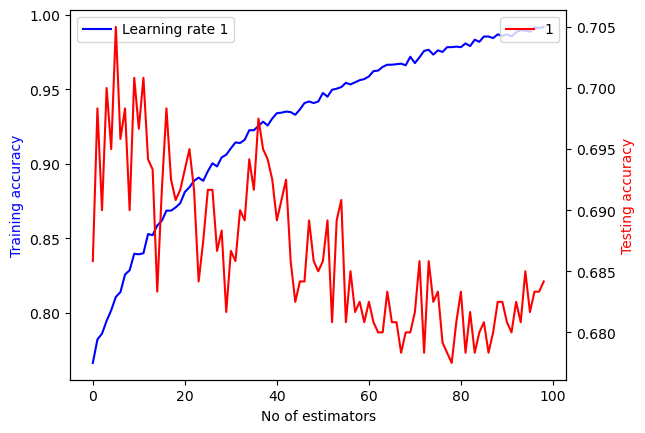

In [44]:
get_accuracy_bag(X,y,title="Training and Test Accuracy vs Weak Classifiers",Learning_rate_=[1],times=20,xlabel='Number Estimators')

As you can see, as the number of classifiers increases so does the overfitting; the training accuracy increases and conversely, the testing accuracy decreases. One way to decrease overfitting is using the learning rate <code>learning_rate</code> with a default value of 1. This is a type of Regularization. For more detail on Regularization, check out <a href="https://hastie.su.domains/Papers/ESLII.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01#page=383">here</a>.


In [46]:
n_estimators=100
random_state=0
learning_rate=0.7

We can now train the model, make a prediction, and calculate the accuracy. We see that by increasing the learning rate the test accuracy has improved.


In [48]:
model = AdaBoostClassifier(n_estimators=n_estimators,random_state=random_state,learning_rate=learning_rate)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.75, 'train Accuracy': 0.95}


Compared to the previous results we see the model does better on the test data. We can try different learning rates using the method <code>get_accuracy_bag</code>. In this case, the learning rates are 0.2,0.4,0.6, and 1. As the learning rate goes down we see that the testing accuracy increases while conversely, the training accuracy decreases .


100%|██████████| 20/20 [23:51<00:00, 71.57s/it]


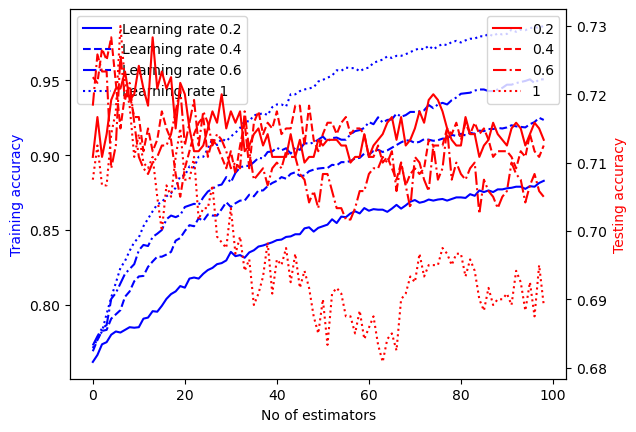

In [50]:
get_accuracy_bag(X,y,title="Training and Test Accuracy vs Weak Classifiers",Learning_rate_=[0.2,0.4,0.6,1],times=20,xlabel='Number Estimators')

Another important parameter is <code>algorithm</code> with takes on the values <code>SAMME</code>, <code>SAMME.R</code>. The default is  <code>’SAMME.R’</code>. The <code>SAMME.R</code> algorithm typically converges faster than <code>SAMME</code>, achieving a lower test error with fewer boosting iterations. For more details, check <a href="https://hastie.su.domains/Papers/samme.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">the paper</a>. One issue is that <code>SAMME.R</code> can't be used all the time as we will need the Base classifier to generate the probability of belonging to each class.


## Changing the Base Classifier


AdaBoost is usually performed with Decision Trees but we can use other base classifiers. However, if the classifier is too strong it will cause overfitting. Consider using the following Support Vector Machine (SVM) as the base classifier:


In [52]:
from sklearn.svm import SVC

In [54]:
base_estimator=SVC(kernel='rbf',gamma=1)

We see the SVM does extremely well:


In [56]:
base_estimator.fit(X_train, y_train)

print(get_accuracy(X_train, X_test, y_train, y_test, base_estimator))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 1.0}


The Base classifier for SVM can not generate the probability of belonging to each class. If you uncomment the following line of code you will get an error.


In [ ]:
#base_estimator.predict_proba(X_train)

Therefore the parameter <code>algorithm</code> must be <code>'SAMME'</code>


In [58]:
algorithm='SAMME'

In [60]:
model =AdaBoostClassifier(n_estimators=5, estimator=base_estimator,learning_rate=1,algorithm='SAMME' )

We see the AdaBoost model does worse, this is similar to overfitting. In addition, SVM takes much longer to train than classification trees:


In [62]:
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.6857142857142857}


We see that each tree in RF is less correlated than Bagging:


<h2 id="Example">Cancer Data Example</h2>

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[[http://mlearn.ics.uci.edu/MLRepository.html](http://mlearn.ics.uci.edu/MLRepository.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

Let's load the dataset:


In [64]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv")

df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now lets remove rows that have a ? in the <code>BareNuc</code> column:


In [66]:
df= df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]

We obtain the features:


In [68]:
X =  df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]

X.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


We obtain the class labels:


In [70]:
y=df['Class']
y.head()

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

We split the data into training and testing sets.


In [72]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


We use <code>GridSearchCV</code> to search over specified parameter values of the model.


In [74]:
from sklearn.model_selection import GridSearchCV

We create a <code>AdaBoost</code> object and list the parameters using the method <code>get_params()</code>:


In [76]:
model = AdaBoostClassifier()
model.get_params().keys()

dict_keys(['algorithm', 'estimator', 'learning_rate', 'n_estimators', 'random_state'])

We can use GridSearch for Exhaustive search over specified parameter values. We see many of the parameters are similar to Classification trees; let's try different parameters for <code>learning_rate</code>, <code>n_estimators</code>, and <code>algorithm</code>.


In [78]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(10)],
             'n_estimators' : [2*n+1 for n in range(10)],
              'algorithm':['SAMME', 'SAMME.R']}                

param_grid 

{'learning_rate': [0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0],
 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'algorithm': ['SAMME', 'SAMME.R']}

We create the Grid Search object and fit it:


In [80]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6000000000000001,
                                           0.7000000000000001, 0.8, 0.9, 1.0],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

We can see the best accuracy score of the searched parameters was \~96%.


In [82]:
search.best_score_

0.9689074228523771

The best parameter values are:


In [84]:
search.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 17}

We can calculate accuracy on the test data using the test data:


In [86]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9708029197080292, 'train Accuracy': 0.9725274725274725}


<h2 id="practice">Practice</h2>


Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.


In [88]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


Let's create the X and y for our dataset:


In [90]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [92]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

Now lets use a <code>LabelEncoder</code> to turn categorical features into numerical:


In [94]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Split the data into training and testing data with a 80/20 split.


In [96]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 5) (160,)
Test set: (40, 5) (40,)


We can use GridSearch for Exhaustive search over specified parameter values.


In [98]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(10)],
             'n_estimators' : [2*n+1 for n in range(10)],
              'algorithm':['SAMME', 'SAMME.R']}                

param_grid 


{'learning_rate': [0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0],
 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'algorithm': ['SAMME', 'SAMME.R']}

Create a <code>AdaBoostClassifier</code> object called <code>model</code> :


In [102]:
model = AdaBoostClassifier()

Create <code>GridSearchCV</code> object called `search` with the `estimator` set to <code>model</code>, <code>param_grid</code> set to <code>param_grid</code>, <code>scoring</code> set to <code>accuracy</code>, and <code>cv</code> set to 3 and Fit the <code>GridSearchCV</code> object to our <code>X_train</code> and <code>y_train</code> data.


In [104]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy', cv=3)
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6000000000000001,
                                           0.7000000000000001, 0.8, 0.9, 1.0],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

We can find the accuracy of the best model.


In [106]:
search.best_score_

0.8625669694852084

We can find the best parameter values:


In [108]:
search.best_params_

{'algorithm': 'SAMME', 'learning_rate': 0.9, 'n_estimators': 7}

We can find the accuracy test data:


In [110]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.775, 'train Accuracy': 0.85}
